# <!-- TITLE --> Physics Informed Neural Networks appliqués à l'équation de Burgers

## Les étapes principales de ce Notebook :
 - Initialisation et lancement des **piles logiciels** ;
 - Création du **dataset** ;
 - **Création du modèle** : réseau de neurones, calcul des gradients et modèle PINN ;
 - **Entrainement** du modèle PINN ;
 - **Visualisation des résultats** de l'entrainement.

## Etape 1 -  Importation et initialisation

### 1.1 - Importation

Dans un premier temps, nous allons lancer toutes les piles logicielles nécessaires au bon fonctionnement de ce notebook et des commandes utilisées. Les principales piles logicielles utiles sont décrites ci-dessous :
 - NumPy est une bibliothèque pour le langage de programmation Python, conçue pour manipuler des matrices ou des tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux ;
 - PyTorch est une bibliothèque logicielle Python open source d'apprentissage machine qui s'appuie sur Torch développée par Facebook. PyTorch permet d'effectuer les calculs tensoriels nécessaires notamment pour l'apprentissage profond ;
 - Pandas est une bibliothèque écrite pour le langage de programmation Python permettant la manipulation et l'analyse des données. Elle propose en particulier des structures de données et des opérations de manipulation de tableaux numériques et de séries temporelles ;
 - Matplotlib.pyplot est une interface basée sur l'état à matplotlib. Elle fournit une manière implicite, semblable à MATLAB, de tracer. Il ouvre également les figures sur votre écran, et agit comme le gestionnaire de l'interface graphique des figures.

In [1]:
# !nvidia-smi 
# !lscpu
# %conda uninstall pytorch
# %conda install pytorch torchvision torchaudio cudatoolkit=11.4 -c pytorch
# %conda install pandas
# %conda install numpy
# %conda install ipython
# %conda install torchvision
# %pip install torchsummary
# %conda install matplotlib
# %conda install ipympl
# %conda install scipy
# %conda update -n base conda
# %conda install imagemagick
# !pip install ipympl

In [2]:
######################################
# Pour le fonctionnement du notebook #
######################################
import numpy as np
from IPython.display import display, clear_output, HTML
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchsummary import summary
from torch.autograd import Variable
from torch.optim import Adam, LBFGS
import time, csv, random
# from scipy.stats import qmc
##################################################
# Pour déterminer si on utilise un cpu ou un gpu #
##################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("On utilise ",device)
# print(torch.cuda.is_available())
####################
# Pour l'affichage #
####################|
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
def animate_show(anim):
    html_version = HTML(anim.to_jshtml())
    return html_version
import matplotlib.animation as animation

On utilise  cuda:0
True


### 1.2 - Initialisation
Nous allons maintenant définir de nombreux paramètres qui sont utiles pour définir l'équation de Burgers et les conditions initiales : la viscosité cinématique ($\nu$), la discrétisation temporelle ($t_0$, $t_f$, $pasT$) et spatiale ($x_a$, $x_b$, $pasX$) ainsi que la donnée initiale ($u_d$, $u_g$, $x_0$). Nous définirons aussi les paramètres utiles dans le but de modifier la façon dont on utilise notre modèle PINN que nous verrons plus tard : le nombre d'échantillons, le nombre de paramètres d'entrées, l'algorithme d'optimisation ainsi que la fonction de perte que l'on veut utiliser.

In [3]:
######################
# Paramètres Burgers #
######################
# Viscosité cinématique
nu = torch.tensor(0.01/np.pi)
# Discrétisation spatiale
xa = 0; xb = 2; pasX = 0.04
# Discrétisation temporelle
t0 = 0; tf = 1; pasT = 0.02
# Donnée initiale
ud = 0; ug = 1; x0 = 0.5

###################
# Paramètres PINN #
###################
# Nombre d'échantillons
taille_dataset = 1500
# Nombre de paramètres en entrée / sortie
nombre_entrees = 2; nombre_sortie = 1
# Nombre de neurones par couches cachées et architecture du réseau
nr = 3; L = [2,nr,nr,nr,1]; nombre_couches = len(L);
# Critère d'arrêt
epsilon=1e-4
# Fonction de perte
fct_perte = nn.MSELoss()

## Etape 2 -  Création du dataset
Pour créer le dataset, nous allons procéder en trois étapes. Dans un premier temps, il s'agira de créer un fichier csv contenant les données initiales, $x$, $t$ et $u(x,t=0)$, correspondantes à la donnée de Riemann définit dans les paramètres de l'équation de Burgers lors de l'étape 1 de ce Notebook. Dans un deuxième temps, nous définissons une classe permettant de créer le dataset à partir d'un fichier csv contenant les données d'entrainement du modèle. Dans un troisième temps, nous créons le dataset à l'aide du fichier csv et de la classe qui ont étés créé précedemment, qui nous servira à définir notre dataloader. Un dataloader peut être utilisé pour itérer dans les données, gérer les lots, transformer les données, et bien plus encore.

In [4]:
######################################################
# Création du fichier .csv qui va définir le dataset #
######################################################
## Création des données initiales u(x,t=0)
Heav = lambda x: ug if x < x0 else ud
applatir  = lambda liste: [item for souslist in liste for item in souslist]
# Ouverture du fichier en mode écriture "Write"
fichier = open("Dataset_6_"+str(taille_dataset)+".csv", "w") 
ecriture = csv.writer(fichier, delimiter=",")
ecriture.writerow(['x','t','Init'])
## On remplit le fichier .csv avec les valeurs
    ###########
    # Uniform #
    ###########
for i in range(taille_dataset):
   x = np.random.uniform(xa, xb)
   pair = [x,t0,Heav(x)]
   ecriture.writerow(pair)
    #########
    # SOBOL #
    #########
#echantilloneur = qmc.Sobol(d=1, scramble=False)
#echantillon = echantilloneur.random_base2(m=11)
#print(applatir(echantillon))
#print(echantillon)
    #################
    # PSEUDO-RANDOM #
    #################
#rng = np.random.default_rng(seed=42)
#echantillon = rng.random((taille_dataset,1))
# -------------------------------------------------- Pseuo Random RNG par defaut
#for x in applatir(echantillon):
#     ecriture.writerow([x,t0,Heav(x)])

##Fermeture du fichier
fichier.close()
# # On importe le fichier .csv que l'on vient de créer
df = pd.read_csv(r'./Dataset_6_'+str(taille_dataset)+'.csv')#,header=0)
df.columns = ['x','t','Init']
# On affiche le fichier .csv
display(df)

##############################################
# Création d'une classe qui crée le dataset  #
##############################################
class MyDataset(Dataset):
    def __init__(self,file_name):
        # On lis le dataset
        df=pd.read_csv(file_name,nrows=taille_dataset)
        # On alloue les valeurs aux vecteurs x et t : conditions initiales
        inputs_x_t=df.iloc[:,0:nombre_entrees].values
        output_u=df.iloc[:,nombre_entrees].values
        # On transforme les vecteurs en tenseurs
        self.pt_inputs_x_t=torch.tensor(inputs_x_t,dtype=torch.float32)
        self.pt_output_u=torch.tensor(output_u,dtype=torch.float32).reshape([taille_dataset,1])
    
    def __len__(self):
        return len(self.pt_output_u)

    def __getitem__(self,idx):
        return self.pt_inputs_x_t[idx],self.pt_output_u[idx]

##########################################
# Création du dataset et d'un dataloader #
##########################################
# Création du dataset final à partir de la classe MyDataset
myds=MyDataset('Dataset'+str(taille_dataset)+'.csv')
# myds=MyDataset('Dataset1500v1.csv')
# Création d'un dataloader à partir du dataset final
myds_loader=DataLoader(myds,taille_dataset,shuffle=False)

## Etape 3 -  Implémentation du modèle
Cette partie est consacrée à la création de notre modèle tel qu'il a été défini au début de ce Notebook. Celui-ci sera décomposé en deux parties puisque nous devons d'abord définir notre réseau de neurones, puis nos opérateurs définissant nos dérivés temporels et spatiales permettant de décrire l'équation de Burgers.

### Etape 3.1 - Réseau de neurones
Pour créer notre réseau de neurones, nous avons définit une classe permettant de créer ce réseau avec une couche d'entrée possédant deux neurones (2 variables d'entrées qui sont $x$ et $t$), des couches cachées ainsi qu'une couche de sortie possédant un seul neurone (1 variable de sortie qui est $u$). Nous définissons également la fonction d'activation des neurones, qui est dans notre cas la fonction $Tanh$, qui est la plus efficace lorsque l'on est en présence de solutions discontinues.

In [5]:
#####################################
# Choix de la fonction d'activation #
#####################################
    ##############
    # Classiques #
    ##############
activation = nn.Tanh() # Tangente hyperbolique 
#activation = nn.Sigmoid()  
#activation = nn.Tanhshrink()
#activation = nn.Hardtanh(-2, 2)
#activation = nn.Hardswish()
#activation = nn.SiLU()
#activation = nn.ReLU()
    #############################
    # Définition d'une fonction d'activation custom
    #############################
# class custom_activation(nn.Module):
#     def __init__(self):
#         super(custom_activation, self).__init__()
    
#     def forward(self, x):
#         x[x<=x0] = Ug
#         x[x>x0] = Ud
#         return x
#activation = custom_activation()
#activation = lambda x: torch.sin(x); # Sine

########################################################
# Création d'une classe qui crée le réseau de neurones #
########################################################
class Reseau(nn.Module):
    def __init__(self,couches):
        # L=[2,3,3,3,1];
        super().__init__()
        # Création de la couche d'entrée
        self.couche_entree = nn.Linear(couches[0],couches[1])
        # Création des couches cachées
        self.couches_cachees = nn.ModuleList()
        for i in range(1, len(couches)-2):
            self.couches_cachees.append(nn.Linear(couches[i], couches[i+1]))
        # Création de la couche de sortie
        self.couches_sortie = nn.Linear(couches[-2], couches[-1])
    
    # Propagation
    def forward(self,data):
        u = activation(self.couche_entree(data))
        for l in self.couches_cachees:
            u = activation(l(u))
        u = self.couches_sortie(u)
        return u
    
##################################
# Création du réseau de neurones #
##################################
# Création de notre réseau
modele = Reseau(L).to(device)
# On le met en mode entrainement
modele.train()
# # On affiche le modèle
display(modele) 
summary(modele,(1,2))

Reseau(
  (couche_entree): Linear(in_features=2, out_features=3, bias=True)
  (couches_cachees): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=3, bias=True)
  )
  (couches_sortie): Linear(in_features=3, out_features=1, bias=True)
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 3]               9
            Linear-2                 [-1, 1, 3]              12
            Linear-3                 [-1, 1, 3]              12
            Linear-4                 [-1, 1, 1]               4
Total params: 37
Trainable params: 37
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Etape 3.2 - Calcul des gradients
Nous avons définit une fonction de cout correspondante à l'équation de Burgers modifié. Cette fonction est définit à partir de la sortie de notre réseau de neurones. Nous nous servons ensuite de la fonction autograd, qui est un système de différenciation automatique inverse de PyTorch. Cela nous permet de calculer les différentes dérivées présentes dans l'équation de Burgers et donc d'obtenir notre fonction de cout, notée $f$.

In [6]:
###############################################################
# Transformation de l'équation de Burgers en fonction de cout #
###############################################################
def f(x,t):
    # On définit la sortie u à partir des données x et t
    Donnees_entrees=torch.cat((x, t),1)
    u = modele(Donnees_entrees)
    # On définit la dérivée spatiale
    u_x = torch.autograd.grad(u, x, torch.ones_like(u),retain_graph=True,create_graph=True)[0]
    # On définit la dérivée temporelle
    u_t = torch.autograd.grad(u, t, torch.ones_like(u),retain_graph=True,create_graph=True)[0]
    # On définit la dérivée seconde spatiale
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True,create_graph=True)[0]
    # Résidu de l'équation différentielle
    edp = u_t + u*u_x - nu*u_xx
    return edp

## Etape 4 - Entrainement du modèle PINNs

Nous allons maintenant créer puis entrainer notre modèle PINNs qui est définit à partir du dataloader, du modèle de réseau de neurones, de la fonction cout ainsi que des paramètres définit au début de ce Notebook.

In [7]:
###############
# Modèle PINNs #
###############
# Pour afficher l'entrainement du réseau de neurones au cours des époques
EPOQUES = []; PERTE = []

# Boucle tant que la fonction de perte est supérieure au critère d'arrêt
start = time.time()
test = 10
epoques=0; epoques_total = 6000
while (test > epsilon and epoques < epoques_total):
    MaJ_perte = 0.0
    # Parcours les valeurs du dataloader
    for i, (data, labels) in enumerate(myds_loader):
        x_ = data.clone().detach().requires_grad_(True).to(device)
        y_ = labels.clone().detach().requires_grad_(True).to(device)
        
        #######################
        # Optimisateur L-BFGS #
        #######################
        if (epoques > epoques_total):
            optimizer = LBFGS(modele.parameters(), 
                              lr=2e-4,
                              max_iter=20,
                              max_eval=None,
                              tolerance_grad=1e-07, 
                              tolerance_change=1e-09,
                              history_size=100, 
                              line_search_fn=None)
            def closure():
                # Gradients nuls
                optimizer.zero_grad()
                # Propagation vers l'avant
                y_pred = modele(x_)
                # Fonctions de cout de l'EDP
                x_colloc = np.random.uniform(xa, xb, size=(taille_dataset,1))
                t_colloc = np.random.uniform(t0, tf, size=(taille_dataset,1))
                x_colloc_tens = torch.tensor(x_colloc,requires_grad=True).float().to(device)
                t_colloc_tens = torch.tensor(t_colloc,requires_grad=True).float().to(device)
                f_out = f(x_colloc_tens,t_colloc_tens) 
                zeros_tens = torch.tensor(np.zeros((taille_dataset,1)),requires_grad=True).float().to(device)
                # Calcul de la fonction de perte totale (mse_u+mse_f)
                perte = fct_perte(y_pred, y_)+fct_perte(f_out, zeros_tens)
                # Propagation vers l'arrière
                perte.backward(retain_graph=True)
                return perte
            # Mise à jour des poids
            optimizer.step(closure)
            # Mise à jour de la fonction de perte
            perte = closure()
            test = perte.item()
            MaJ_perte += test
            epoques += 1

        #####################
        # Optimisateur ADAM #
        #####################
        else:
            optimizer = Adam(modele.parameters(),lr=7.5e-4)    
            # Gradients nuls
            optimizer.zero_grad()
            # Propagation vers l'avant
            y_pred = modele(x_)
            # Fonctions de cout de l'EDP
            x_colloc = np.random.uniform(xa, xb, size=(taille_dataset,1))
            t_colloc = np.random.uniform(t0, tf, size=(taille_dataset,1))
            x_colloc_tens = torch.tensor(x_colloc,requires_grad=True).float().to(device)
            t_colloc_tens = torch.tensor(t_colloc,requires_grad=True).float().to(device)
            f_out = f(x_colloc_tens,t_colloc_tens) 
            zeros_tens = torch.tensor(np.zeros((taille_dataset,1)),requires_grad=True).float().to(device)
            # Calcul de la fonction de perte totale (mse_u+mse_f)
            perte = fct_perte(y_pred, y_)+fct_perte(f_out, zeros_tens)
            # Propagation vers l'arrière
            perte.backward(retain_graph=True)
            # Mise à jour des poids
            optimizer.step()
            # Mise à jour de la fonction de perte
            test = perte.item()
            MaJ_perte += test
            epoques += 1
    
    PERTE.append(perte.item()); EPOQUES.append(epoques)
    
    # Affichage de la valeur de la fonction de perte au cours des époques
    with torch.autograd.no_grad():
        if epoques % 200 == 0:
            print("Epoques: ", epoques, "Loss:", perte.item())
# Calcul du temps d'apprentissage
end = time.time(); temps = end - start
print("L'apprentissage est fini! Temps d'apprentissage: ",temps)

Epoques:  200 Loss: 0.19082799553871155
Epoques:  400 Loss: 0.12634451687335968
Epoques:  600 Loss: 0.08118250966072083
Epoques:  800 Loss: 0.07340864837169647
Epoques:  1000 Loss: 0.062118519097566605
Epoques:  1200 Loss: 0.05026300624012947
Epoques:  1400 Loss: 0.042350150644779205
Epoques:  1600 Loss: 0.04034318029880524
Epoques:  1800 Loss: 0.03926030173897743
Epoques:  2000 Loss: 0.03773952275514603
Epoques:  2200 Loss: 0.03502044826745987
Epoques:  2400 Loss: 0.033738695085048676
Epoques:  2600 Loss: 0.031233619898557663
Epoques:  2800 Loss: 0.031065743416547775
Epoques:  3000 Loss: 0.029545359313488007
Epoques:  3200 Loss: 0.02592342719435692
Epoques:  3400 Loss: 0.023359060287475586
Epoques:  3600 Loss: 0.019297407940030098
Epoques:  3800 Loss: 0.014644984155893326
Epoques:  4000 Loss: 0.00902051292359829
Epoques:  4200 Loss: 0.0025935349985957146
Epoques:  4400 Loss: 0.0005303082871250808
Epoques:  4600 Loss: 0.0004084387328475714
Epoques:  4800 Loss: 0.0004159547679591924
Epo

Vous pouvez observer ci-dessous la courbe d'apprentissage :

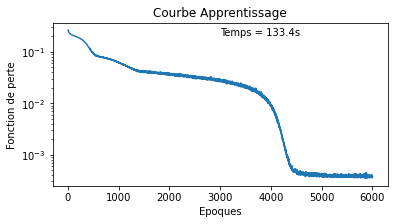

In [8]:
##########################################
# Affichage de la courbe d'apprentissage #
##########################################
fig1 = plt.figure(figsize= (6,3))
plt.plot(EPOQUES,PERTE)
plt.text(max(EPOQUES)/2,max(PERTE)*0.8, 'Temps = %.1fs' % (temps))
plt.title('Courbe Apprentissage')
plt.xlabel('Epoques')
plt.ylabel('Fonction de perte')
plt.yscale('log')
plt.show()

In [9]:
###########################################
# Sauvegarde de la courbe d'apprentissage #
###########################################
def ecriture(nomdufichier,x,y,labelx,labely):
    # fichier_apprentissage = open("Dataset_lr_2e-3.csv", "w") 
    fichier = open(nomdufichier,"w")
    ecrit = csv.writer(fichier, delimiter=",")
    ecrit.writerow([labelx,labely])
    # On remplit le fichier .csv avec les valeurs
    ecrit.writerows(zip(x,y))
    # Fermeture du fichier
    fichier.close()

ecriture("./Courbe_Apprentissage.csv",EPOQUES,PERTE,"EPOQUES","PERTE")

## Etape 5 - Visualisation
### Etape 5.1 - Calcul de la solution exacte

In [10]:
############################################
# Solution exacte de l'équation de Burgers #
############################################
def sol_exacte_Burgers(x,t,ud,ug,x0):
    u_exact=np.zeros((len(t),len(x)))
    for j in range(len(t)):
        if t[j]==0:
            for i in range(len(x)):
                if x[i]<=x0:
                    u_exact[j,i]=ug
                else:
                    u_exact[j,i]=ud
        else:
            for i in range(len(x)):
                if ud<ug:
                    sigma=0.5*(ud**2-ug**2)/(ud-ug)
                    if (x[i]-x0)/t[j]<sigma:
                        u_exact[j,i]=ug
                    else:
                        u_exact[j,i]=ud
                else:
                    if (x[i]-x0)/t[j]<ug:
                        u_exact[j,i]=ug
                    elif ug<=(x[i]-x0)/t[j]<=ud:
                        u_exact[j,i]=(x[i]-x0)/t[j]
                    else:
                        u_exact[j,i]=ud
    return u_exact

# Calcul de la solution exacte de l'équation de Burgers
y_sol_exacte=sol_exacte_Burgers(np.arange(xa,xb,pasX),np.arange(t0,tf,pasT),ud,ug,x0)
modele.eval()

Reseau(
  (couche_entree): Linear(in_features=2, out_features=3, bias=True)
  (couches_cachees): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=3, bias=True)
  )
  (couches_sortie): Linear(in_features=3, out_features=1, bias=True)
)

### Etape 5.2 - Projection 3D des résultats

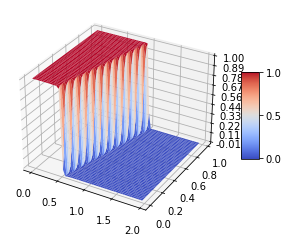

In [11]:
#################################################
# Projection 3D des résultats de l'entrainement #
#################################################
# Création de la figure
fig2 = plt.figure()
ax = plt.subplot(projection='3d')
# Création des données de la figure à partir du modèle PINN entrainé
x=np.arange(xa,xb,pasX)
t=np.arange(t0,tf,pasT)
ms_x, ms_t = np.meshgrid(x, t)
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)
x_tens = torch.from_numpy(x).float().to(device)
t_tens = torch.from_numpy(t).float().to(device)
u_tens = modele(torch.cat((x_tens, t_tens),1))
u=u_tens.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)
# Affichage des résultats
surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,edgecolor='none')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig2.colorbar(surf, shrink=0.4, aspect=5)
plt.show()

### Etape 5.3 - Résultats sous forme d'animation

In [12]:
#######################################
# Animation 1D à partir des résultats #
#######################################
# Création de la figure pour l'affichage de l'animation
fig3 = plt.figure() 
plt.xlabel("Position x")
plt.ylabel("Burgers u")
plt.title("Evolution de la solution de Burgers au cours du temps")
# Pour l'affichage des courbes
line1, = plt.plot([], [], label="Solution PINN") 
line2, = plt.plot([], [], label="Solution exacte")
plt.legend()
# Pour l'affichage du temps
time_template = 'time = %.1fs'
time_text = plt.text(0.0, xb+0.1, '')
# Pour la taille du graphique
marge=0.25
plt.xlim(xa-marge*0.5, xb+marge*1.5)
plt.ylim(-marge, max(ud,ug)+marge)
# Création de l'animation
def animate(i):
    y = ms_u[i,:]
    x = ms_x[i,:]
    line1.set_data(x, y)
    line2.set_data(x, y_sol_exacte[i,:])
    time_text.set_text(time_template % (i*pasT))
    return line1, line2, time_text
ani = animation.FuncAnimation(fig3, animate, frames=len(ms_u), blit=True, interval=1, repeat=False)
plt.close(fig3)
animate_show(ani)

In [13]:
########################
# Sauvegarde du modèle #
########################
torch.save(modele,"./modele.pt ")